In [1]:
import pandas as pd
import numpy as np
from math import acos, sin, cos, tan

import matplotlib.pyplot as plt

# Need to download LaTex, dviping, and Ghostscript to use tex
# https://stackoverflow.com/questions/58121461/runtimeerror-failed-to-process-string-with-tex-because-latex-could-not-be-found

#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "sans-serif",
#    "font.sans-serif": ["Helvetica"]})


In [2]:
def sind(x):
    return sin(np.deg2rad(x))

def cosd(x):
    return cos(np.deg2rad(x))

def tand(x):
    return tan(np.deg2rad(x))

def acosd(x):
    return np.rad2deg(acos(x))

In [3]:
def readCSV(filename):
    with open(filename) as csvDataFile:
        # Read file as csv
        df = pd.read_csv(csvDataFile)
    return df


def nasa_pres(P, P0=101.29, T0=288.08):
    T = T0*((P / P0)**(1 / 5.256)) - 273.1
    h = (T-15.04)/(-0.00649)
    return h


################## CONSTANTS ##################
# gravity
g = 9.81  # m/s^2
# m to ft
ft = 3.2884  # ft/m

################## DATA FRAME ##################
datafile = '../Fullscale21.csv'
fields = ['Timestamp', 'Pres', 'Temp',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z',
  'Yaw', 'Pitch', 'Roll']
df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

################## INIT VECTORS ##################
t_IMU = df['Timestamp'].values
yaw_IMU = df['Yaw'].values
pitch_IMU = df['Pitch'].values
roll_IMU = df['Roll'].values

t_IMU = t_IMU - t_IMU[0]

In [4]:
# These are the curves from their simulations... we don't have these

#theta_sim = theta;
#i_apogee_sim = i_apogee;
#i_apogee_sim = find(round(tr,2) == 16.96);

## Find Flight Events

# These numbers are wrong.  They must've edited their CSVs
#iIMU_MECO = np.where(np.round(t_IMU,3) == 1.974);
#i_apogee = np.where(np.round(t_IMU,2) == 16.50);
#i_apogee = np.where(np.round(t_IMU,2) == 17.21);

## Trim to Apogee
# Note that I already did this above with [start:stop]
# *** YAW = ROLL ***
t_array = t_IMU#[0:i_apogee]
gamma_array = yaw_IMU#[0:i_apogee]
alpha_array = pitch_IMU#[0:i_apogee]
beta_array = roll_IMU#[0:i_apogee]

In [5]:
N = len(t_array)

# Preallocate
angle_array = np.zeros(N)  # angle
n_array = np.zeros((3,N))   # axis
theta_array = np.zeros(N)   # resolved angle

In [6]:
## Calculate

# iterate until apogee
for i in range(N):
    
    alpha = alpha_array[i]
    beta = beta_array[i]
    gamma = gamma_array[i]
    
    # yaw
    R_alpha = np.array([[1, 0, 0],
               [0, cosd(alpha), -sind(alpha)],
               [0, sind(alpha), cosd(alpha)]])
           
    # pitch
    R_beta = np.array([[cosd(beta), 0, sind(beta)],
              [0, 1, 0],
              [-sind(beta), 0, cosd(beta)]])
          
    # roll
    R_gamma = np.array([[cosd(gamma), -sind(gamma), 0],
               [sind(gamma), cosd(gamma), 0],
               [0, 0, 1]])
    
    R = R_gamma*R_beta*R_alpha
    
    # calculate angle
    angle = acosd((np.trace(R) - 1)/2)
    angle_array[i] = angle

    # theta
    theta = acosd(np.dot(R[:,2], [0, 0, 1]))
    theta_array[i] = theta

In [7]:
# Theta vs Time
pitch_array = -1*theta_array
pitch_array = pitch_array - pitch_array[0]
t_pre_apog = t_array[t_array < 17.21]
i_apogee = t_pre_apog.shape[0]
pitch_array_apog = pitch_array[0:i_apogee]

# Pitch vs Time
gamma_array = gamma_array[0:i_apogee]

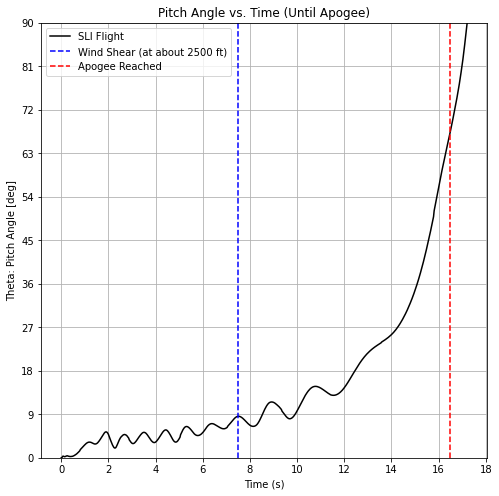

In [8]:
# Theta vs. Time
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l1 = ax.plot(t_pre_apog, pitch_array_apog, color='black', label='SLI Flight')
l2 = plt.axvline(x=7.5, color='blue', linestyle="--", label='Wind Shear (at about 2500 ft)')
l3 = plt.axvline(x=16.5, color='red', linestyle="--", label='Apogee Reached')

plt.grid()
plt.yticks(np.linspace(0,90, num=11))
plt.ylim((0, 90))
plt.xticks(np.linspace(0,18, num=10))


ax.set_title("Pitch Angle vs. Time (Until Apogee)")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Theta: Pitch Angle [deg]")
ax.legend(loc=2)
plt.show()

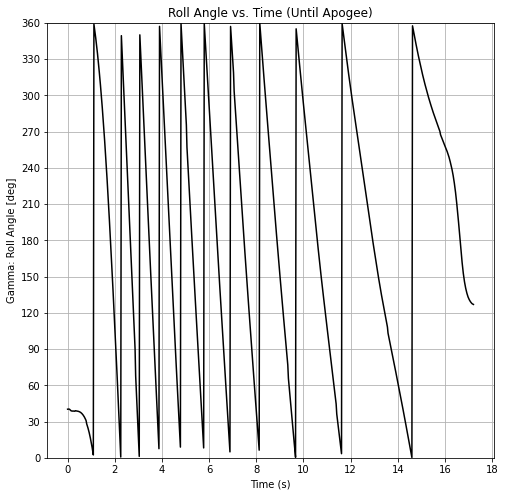

In [9]:
## Roll Plot

# Roll vs. Time
fig2 = plt.figure(2, figsize=(8,8))
ax2 = plt.subplot(111)
l1 = ax2.plot(t_pre_apog, gamma_array+180, color='black', label='SLI Flight')

plt.grid()
plt.ylim((0, 360))
plt.yticks(np.linspace(0,360, num=13))
plt.xticks(np.linspace(0,18, num=10))

ax2.set_title("Roll Angle vs. Time (Until Apogee)")
ax2.set_xlabel('Time (s)')
ax2.set_ylabel("Gamma: Roll Angle [deg]")
plt.show()

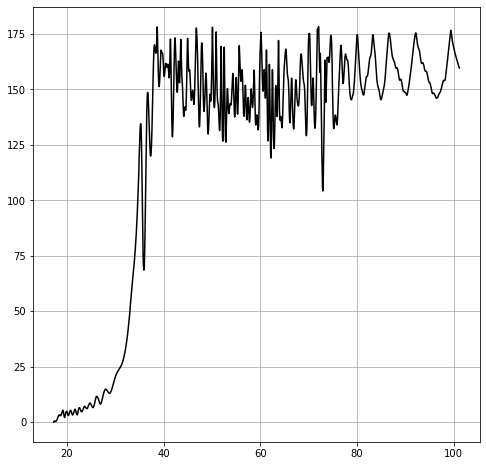

In [10]:
# Theta vs. Time
pitch_array = -1*theta_array
pitch_array = pitch_array - pitch_array[0]
t_post_apog = t_array[t_array > 17.21]
i_post_apogee = t_post_apog.shape[0]
pitch_array_post_apog = pitch_array[0:i_post_apogee]

fig5 = plt.figure(5, figsize=(8,8))
ax5 = plt.subplot(111)
l5 = ax5.plot(t_post_apog, pitch_array_post_apog, color='black', label='SLI Flight')

plt.grid()
#plt.yticks(np.linspace(0,90, num=11))
#plt.ylim((0, 90))
#plt.xticks(np.linspace(0,18, num=10))


ax.set_title("Pitch Angle vs. Time (Post Apogee)")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Theta: Pitch Angle [deg]")
ax.legend(loc=2)
plt.show()

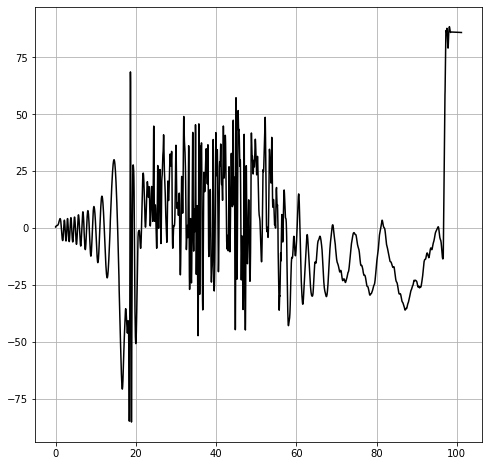

In [12]:
# Theta vs. Time
pitch_array = -1*theta_array
pitch_array = pitch_array - pitch_array[0]
t_post_apog = t_array[t_array > 17.21]
i_post_apogee = t_post_apog.shape[0]
pitch_array_post_apog = pitch_array[0:i_post_apogee]

fig5 = plt.figure(5, figsize=(8,8))
ax5 = plt.subplot(111)
l5 = ax5.plot(t_IMU, pitch_IMU, color='black', label='SLI Flight')

plt.grid()
ax.set_title("Pitch Angle vs. Time (Post Apogee)")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Theta: Pitch Angle [deg]")
ax.legend(loc=2)
plt.show()